In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
import os
import sys
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("recomm.txt", sep=" ",)

In [3]:
dataset.columns.get_values()

array(['movie', 'user', 'movie_ID', 'watch_flag'], dtype=object)

In [4]:
dataset.head()

,movie,user,movie_ID,watch_flag
0,...AND_JUSTICE_FOR_ALL,8220199100312385,42,1
1,...AND_JUSTICE_FOR_ALL,8499053340192848,42,0
2,...AND_JUSTICE_FOR_ALL,8497505080001762,42,0
3,...AND_JUSTICE_FOR_ALL,8771101090065695,42,0
4,...AND_JUSTICE_FOR_ALL,8498350064720676,42,0


In [5]:
len(dataset.user.unique()), len(dataset.movie_ID.unique())

(6292, 6082)

In [6]:
dataset.user = dataset.user.astype('category').cat.codes.values
dataset.movie_ID = dataset.movie_ID.astype('category').cat.codes.values

In [7]:
train, test = train_test_split(dataset, test_size=0.2)

In [8]:
train.head()

,movie,user,movie_ID,watch_flag
46422,ALL_ABOUT_EVE,1635,340,0
337695,ICE_SCULPTURE_CHRISTMAS,5071,2284,0
410466,LONE_SURVIVOR,4939,2731,1
795864,THE_RUGRATS_MOVIE,1605,5293,0
398986,LEGEND,5775,2646,1


In [9]:
test.head()

,movie,user,movie_ID,watch_flag
858614,TRUMPED__INSIDE_THE_GREATEST_POLITICAL_UPSET_O...,2933,5704,1
799888,THE_SECRET_LIFE_OF_PETS,6043,5322,1
159650,COP_LAND,4653,1115,1
403685,LIFE,3169,2686,1
452571,MISS_POTTER,475,3011,0


In [10]:
n_users, n_movies = len(dataset.user.unique()), len(dataset.movie_ID.unique())
n_latent_factors = 3

In [11]:
#ensuring GPU devices availability
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15177232302771894480, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8986809495197399696
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10480141420273780415
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15558138266
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5899085688840909618
 physical_device_desc: "device: 0, name: Tesla V100-DGXS-16GB, pci bus id: 0000:07:00.0, compute capability: 7.0", name

In [18]:
from keras.utils.training_utils import multi_gpu_model
import tensorflow as tf

In [52]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

#prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
prod = keras.layers.dot([movie_vec, user_vec], axes=True)
model = keras.Model([user_input, movie_input], prod)

In [40]:
#model = multi_gpu_model(model, gpus=4)
model.compile('adam', 'mean_squared_error')
#model.compile(loss='categorical_crossentropy',optimizer='rmsprop')

In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         18249       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         18879       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [42]:
history = model.fit([train.user, train.movie_ID], train.watch_flag, batch_size=1000*4, epochs=500, verbose=0)

Text(0,0.5,'Train Error')

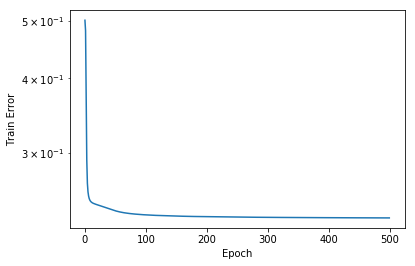

In [43]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [44]:
y_hat = np.round(model.predict([test.user, test.movie_ID]),0)
y_true = test.watch_flag

In [45]:
mean_absolute_error(y_true, y_hat)

0.5039033771158047

In [47]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,6083.000000,6083.000000,6083.000000
mean,0.299730,-0.445552,0.453435
std,0.412835,0.341972,0.331726
min,-1.939038,-2.239938,-1.694258
25%,0.058007,-0.649984,0.256130
50%,0.295304,-0.449241,0.454195
75%,0.534482,-0.240158,0.645739
max,2.748495,1.107047,2.020672


In [48]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,6293.000000,6293.000000,6293.000000
mean,0.299786,-0.445107,0.450517
std,0.603413,0.461280,0.464087
min,-4.911166,-3.436186,-3.017355
25%,0.027414,-0.669571,0.232788
50%,0.294084,-0.457091,0.454890
75%,0.552195,-0.225601,0.669885
max,5.884031,2.540127,2.909406


In [49]:
movie_embedding_learnt

array([[ 0.56233674, -0.25705513,  0.2948589 ],
       [ 0.10676371, -0.2436609 ,  0.5529054 ],
       [ 0.18917465, -0.84790844,  0.04056546],
       ...,
       [ 0.9296982 , -0.03800986,  0.5353325 ],
       [ 0.47961736, -0.15887968,  0.5950842 ],
       [ 0.01936758,  0.00749632, -0.03083106]], dtype=float32)

In [50]:
user_embedding_learnt

array([[-0.28632745, -0.46794978,  0.8253024 ],
       [ 1.0595796 ,  0.11793727,  0.4045592 ],
       [-0.06281154, -0.7094352 ,  0.25713015],
       ...,
       [ 0.60848206, -0.4911196 ,  0.35864455],
       [ 0.10273167, -0.751718  ,  0.2708181 ],
       [-0.03071525, -0.03502067, -0.00233412]], dtype=float32)